In [1]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist

Define function that creates and evolves a random arena

In [2]:
function randArenaEvolve(nCells::Int, steps::Int, growthParams::Union{Tuple, Nothing}=nothing; plotting=false, animating=false)
    arena = buildRandArena(Bounds((0.,10.), (0.,10.)), nCells, 0.08, 0.05, fixSpeed=false)
    
    arenaCellPositions_dim_id = BParts.cellPositions_DIM_ID(arena)

    eKin = BParts.kineticEnergy(arena)
    println("::::: Initial total kinetic energy: ", eKin)

    if animating
        anim = Animation()
    else anim = nothing
    end
    
    posTime_t_dim_id, velTime_t_dim_id, cells_T_ID = 
        evolveArena!(arena, steps, growthParams, plotsteps=plotting, animator=anim)
    
    if animating
        gif(anim, "figures/animation.gif", fps=10)
    end

    eKin = BParts.kineticEnergy(arena)
    println("::::: Final total kinetic energy: ", eKin)

    return arena, posTime_t_dim_id, velTime_t_dim_id, cells_T_ID
end

randArenaEvolve (generic function with 2 methods)

In [3]:
nCells = 100
evolveTime = 1000
arena, posTime_t_dim_id, velTime_t_dim_id, cells_T_ID = randArenaEvolve(nCells, evolveTime);

::::: Initial total kinetic energy: 0.2534350909123694


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


::::: Final total kinetic energy: 0.25343509091236954


In [4]:
using LinearAlgebra, Distributions, Statistics
using Plots
gr()

Plots.GRBackend()

Check speed distribution. Compare it to Rayleigh distribution:

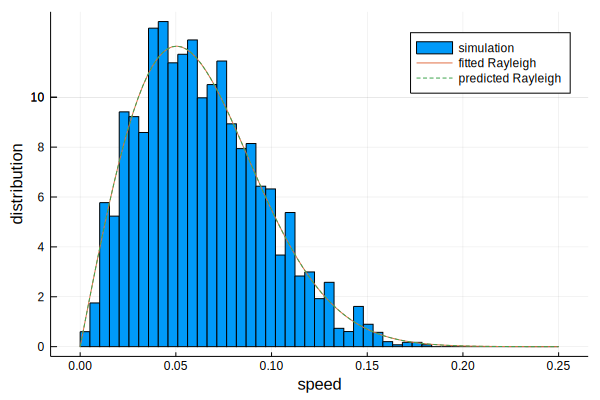

In [5]:
# wait until equilibrium is reached
waitTime = 0

speed_t_id = BParts.speedCalc(velTime_t_dim_id)
rDistFit = BParts.rayleighDistFit(velTime_t_dim_id[1+waitTime:end, :, :])
rDistFitPred = Rayleigh( mean(speed_t_id)*√(2/π) )

p1 = histogram(vec(speed_t_id), bins=range(0, 0.25, length=50), 
    normalize=true, xlabel="speed", ylabel="distribution", label="simulation")
plot!(range(0, 0.25, length=100), pdf.(rDistFit, range(0, 0.25, length=100)), label="fitted Rayleigh")
plot!(range(0, 0.25, length=100), pdf.(rDistFit, range(0, 0.25, length=100)), label="predicted Rayleigh", linestyle=:dash)
display(p1)

Measure mean free path, velocity autocorrelation and mean squared displacement for fixed-size population:

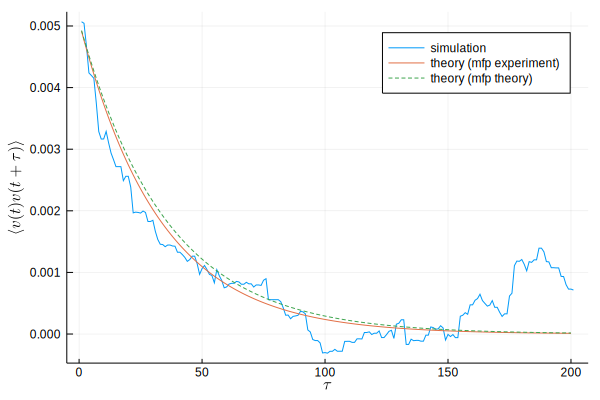

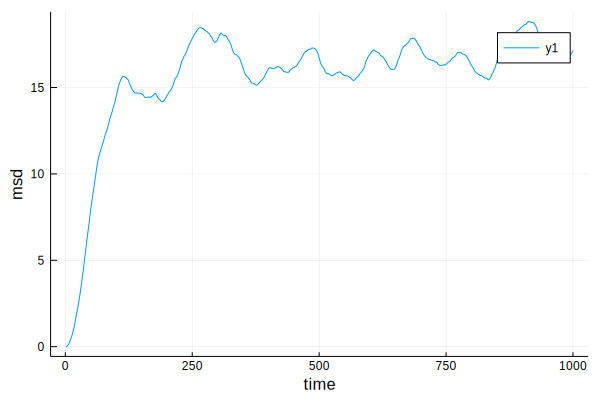

In [6]:
using LaTeXStrings

eKinTot = BParts.kineticEnergy(arena)
# println(eKinTot)

eKinAv = eKinTot / nCells
mfpExp = BParts.meanFreePath(velTime_t_dim_id, 1.)
mfpTheory = Theorist.meanFreePath(nCells/100., 2*2*0.08)
# println(mfpExp)
# println(mfpTheory)
friction = Theorist.friction(mfpExp, eKinAv)
friction2 = Theorist.friction(mfpTheory, eKinAv)

waitTime = 200
corrTime = 200
velCorr_t = BParts.velocityAutocorrelation(velTime_t_dim_id[waitTime:waitTime+corrTime, :, :])
velCorrTheory_t = [Theorist.velocityAutoCorrelation(t, eKinAv, friction) for t in 1:corrTime]
velCorrTheory2_t = [Theorist.velocityAutoCorrelation(t, eKinAv, friction2) for t in 1:corrTime]
p2 = plot(velCorr_t, label="simulation", xlabel=L"\tau", ylabel=L"\left< v(t)v(t+\tau) \right>", dpi=100)
# p2 = plot(velCorr_t, label="simulation", xlabel="\tau", ylabel="E[v(t)v(t+\tau)]", ylims=(-0.0005, 0.005), dpi=100)
plot!(velCorrTheory_t, label="theory (mfp experiment)")
plot!(velCorrTheory2_t, label="theory (mfp theory)", line=(:dash))
display(p2)


msd_t = BParts.meanSquaredDisplacement(posTime_t_dim_id[:,:,:], [10., 10.])
p3 = plot(msd_t)
xlabel!("time")
ylabel!("msd")
display(p3)

In [7]:
using Statistics

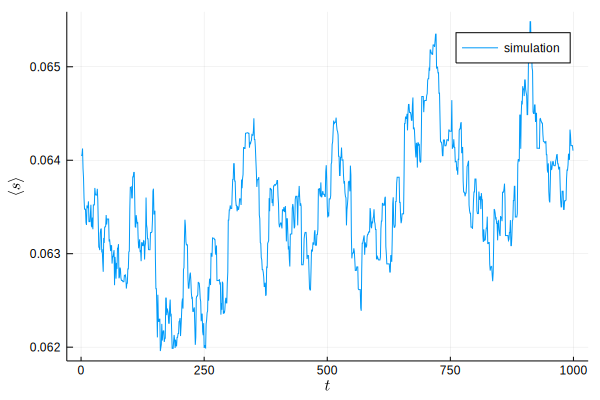

In [8]:
speedAv_t = mean(speed_t_id; dims=2)
p4 = plot(speedAv_t, label="simulation", xlabel=L"t", ylabel=L"\left< s \right>", dpi=100)

## MSD for different densities
As the density of the system increases, cells undergo more collisions, thus we predict the MSD to decrease as the density increase. Note that becuase the cells are spatially constrained the MSD must converge to a maximum value determined by the system's size.

In [9]:
function f()
    evolveTime = 300
    nCells_N = [50, 100, 200, 500]
    msdTime_N = Vector{Float64}[]
    for nCells in [50, 100, 200, 400]
        arena, posTime_t_dim_id, velTime_t_dim_id, cells_T_ID =
            randArenaEvolve(nCells, evolveTime)
        eKinTot = BParts.kineticEnergy(arena)
        msd_t = BParts.meanSquaredDisplacement(posTime_t_dim_id[:,:,:], arena.bounds)
        push!(msdTime_N, msd_t)
    end
    return nCells_N, msdTime_N
end

::::: Initial total kinetic energy: 0.12975137173389287
::::: Final total kinetic energy: 0.12975137173389287
::::: Initial total kinetic energy: 0.23467981981494282


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


::::: Final total kinetic energy: 0.23467981981494285
::::: Initial total kinetic energy: 0.4931682117762574


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


::::: Final total kinetic energy: 0.49316821177625775
::::: Initial total kinetic energy: 1.0864301105932197
anomalous collision time 1.6805871560562597 found in step time 1
A position: 

Progress:   9%|███▊                                     |  ETA: 0:00:03

[0.7255232284342796, 3.8805369638807194]; A speed: 0.017134323911693457
B position: [0.7014641281425656, 3.722356182199906]; B speed: 0.0066156542373216306
anomalous collision time 9.374623049757707 found in step time 1
A position: [0.8201901882427602, 3.7507699965448964]; A speed: 0.013459876106945906
B position: [0.6613040621295144, 3.7696167185072365]; B speed: 0.012497346601750656
anomalous collision time 1.8595161273679084 found in step time 1
A position: [0.8084878364825402, 3.7286453806013187]; A speed: 0.049353599274593714
B position: [0.959364451966993, 3.7819018065042704]; B speed: 0.0710472994393393
anomalous collision time 1.506783511676652 found in step time 1
A position: [0.8388280344995082, 3.7511583181848698]; A speed: 0.04965560770072029
B position: [0.9805910415154476, 3.6769744261206307]; B speed: 0.05551843719701997
anomalous collision time 2.9609613091976086 found in step time 1
A position: [0.8616071663143335, 3.672179888098005]; A speed: 0.07198324398772873
B pos

Progress:  18%|███████▎                                 |  ETA: 0:00:02

anomalous collision time 1.0066040390111497 found in step time 1
A position: [6.564317838846788, 7.329622552356886]; A speed: 0.0381138534701019
B position: [6.638551103384138, 7.47135971204385]; B speed: 0.04076849725630027


Progress:  36%|██████████████▉                          |  ETA: 0:00:01

anomalous collision time 1.282133982236434 found in step time 1
A position: [6.228530738943782, 6.356504285436127]; A speed: 0.08119155888714803
B position: [6.242045901768547, 6.197076118621665]; B speed: 0.09016336881219202
anomalous collision time 21.016709064689422 found in step time 1
A position: [7.8336602599243275, 6.9355464089768635]; A speed: 0.09252718093832507
B position: [7.925854991014798, 7.066313880311121]; B speed: 0.0784870887324472


Progress:  46%|███████████████████                      |  ETA: 0:00:01

anomalous collision time 5.890672959550601 found in step time 1
A position: [9.193063048159498, 1.3780505595991257]; A speed: 0.05363545251629959
B position: [9.240443361378844, 1.2252267855348897]; B speed: 0.019698750840297544
anomalous collision time 5.92446844379913 found in step time 1
A position: [9.498646994548274, 1.290925065263069]; A speed: 0.022870942670044938
B position: [9.338669399678784, 1.2882475403288847]; B speed: 0.05236146037573691
anomalous collision time 5.924468443799129 found in step time 1
A position: [9.641683001433204, 1.3546957988793125]; A speed: 0.04749017383523885
B position: [9.599443377482569, 1.2003720671705798]; B speed: 0.03177240847646184


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


::::: Final total kinetic energy: 1.0864301105932188


In [ ]:
nCells_N, msdTime_N = f();

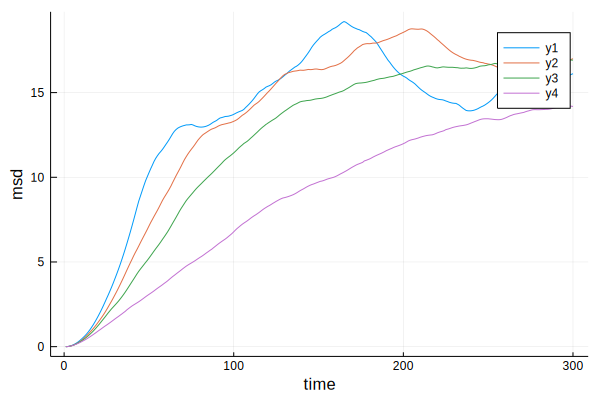

In [12]:
p3 = plot(msdTime_N[1])
for msd_t in msdTime_N[2:end]
    plot!(msd_t)
end
xlabel!("time")
ylabel!("msd")
display(p3)